# Monte Carlo - Arrhenius Degradation 


A monte carlo simulation can be used to predict results of an event with a certain amount of uncertainty. This will be introduced to our use case via mean and standard deviation for each modeling constant. Correlated multivariate monte carlo simulations expand on this by linking the behavior of multiple input variables together with correlation data, in our case we will use correlation coefficients but 

**Objectives**
1. Define necessary monte carlo simulation parameters : correlation coefficients, mean and standard standard deviation, number of trials, function to apply, requried function input
2. Define process for creating and utilizing modeling constant correlation data
3. Preform simple monte carlo simulation using arrhenius equation to calculate degredation and plot

In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.3.3

In [2]:
import pvlib
import numpy as np
import pandas as pd
import pvdeg
import matplotlib.pyplot as plt

In [3]:
# This information helps with debugging and getting support :)
import sys
import platform

print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("Pvlib version ", pvlib.__version__)
print("pvdeg version ", pvdeg.__version__)

Working on a  Windows 11
Python version  3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
Pandas version  2.3.1
Pvlib version  0.13.0
pvdeg version  0.5.1.dev827+g0d99dc8b2


## Correlated Monte Carlo Simulation (parameters)

For this simulation we will be using an arrhenius equation to calculate degredation rate given by $R_D = R_0 * I ^ X * e ^ {\frac{-Ea}{kT}}$, where R0 is prefactor degredation, I is irradiance, X is the irridiance relation, Ea is activation energy and T is degrees K

We will use R0, X and Ea to preform a 3 variable monte carlo simulation to calculate degredation.

### Required inputs
To run a monte carlo simulation with pvdeg.montecarlo the following inputs will be required
- function (currently only works with pvdeg.montecarlo.vecArrhenius() but will eventually work with most pvdeg calculation functions)
- function arguments (ex: metadata, weather, cell temperature, solar position, etc.)
- mean and standard deviation (Required for all correlation constants)
- correlation constants (if not entered, default = 0)
- number of trials to run

### Defining Correlation Coefficients
pvdeg.montecarlo stores correlation coefficients in a ``Corr`` object. To represent a given correlation coefficient follow the given syntax below, replacing the values in the brackets with your correlation coefficients

    {my_correlation_object} = Corr('{variable1}', '{variable2}', {correlation coefficient})

note: ordering of `variable1` and `variable2` does not matter

After defining the all known correlations add them to a list which we will feed into our simulation later

In [4]:
corr_Ea_X = pvdeg.montecarlo.Corr("Ea", "X", 0.0269)
corr_Ea_LnR0 = pvdeg.montecarlo.Corr("Ea", "LnR0", -0.9995)
corr_X_LnR0 = pvdeg.montecarlo.Corr("X", "LnR0", -0.0400)

corr_coeff = [corr_Ea_X, corr_Ea_LnR0, corr_X_LnR0]

In [5]:
type(corr_Ea_X)

pvdeg.montecarlo.Corr

### Defining Mean and Standard Deviation
We will store the mean and correlation for each variable, expressed when we defined the correlation cefficients. If a variable is left out at this stage, the monte carlo simulation will throw errors.

In [6]:
stats_dict = {
    "Ea": {"mean": 62.08, "stdev": 7.3858},
    "LnR0": {"mean": 13.7223084, "stdev": 2.47334772},
    "X": {"mean": 0.0341, "stdev": 0.0992757},
}

# and number of monte carlo trials to run
n = 20000

### Generating Monte Carlo Input Data
Next we will use the information collected above to generate correlated data from our modeling constant correlations, means and standard deviations.

In [7]:
np.random.seed(42) # for reproducibility
mc_inputs = pvdeg.montecarlo.generateCorrelatedSamples(
    corr=corr_coeff, stats=stats_dict, n=n
)
print(mc_inputs)

              Ea       LnR0         X
0      65.748631  12.521613 -0.021520
1      61.058808  14.086270  0.113508
2      66.863698  12.047910  0.056494
3      73.328794  10.002535  0.022482
4      60.350590  14.184631  0.159603
...          ...        ...       ...
19995  64.944415  12.851118 -0.074338
19996  72.252954  10.338032 -0.072373
19997  64.874447  12.835188  0.022460
19998  74.735788   9.549980 -0.191887
19999  50.115596  17.754769  0.014540

[20000 rows x 3 columns]


#### Sanity Check
We can observe the mean and standard deviation of our newly correlated samples before using them for calculations to ensure that we have not incorrectly altered the data. The mean and standard deviation should be the similar (within a range) to your original input (the error comes from the standard distribution of generated random numbers)

This also applies to the correlation coefficients originally inputted, they should be witin the same range as those orginally supplied.

In [8]:
# mean and standard deviation match inputs
for col in mc_inputs.columns:
    print(f"{col} : mean {mc_inputs[col].mean():.10f}, stdev {mc_inputs[col].std():.10f}")

print()

print("Ea_X", round(np.corrcoef(mc_inputs["Ea"], mc_inputs["X"])[0][1], 3))
print("Ea_lnR0", round(np.corrcoef(mc_inputs["Ea"], mc_inputs["LnR0"])[0][1], 3))
print("X_lnR0", round(np.corrcoef(mc_inputs["X"], mc_inputs["LnR0"])[0][1], 3))

Ea : mean 62.1220919316, stdev 7.4023636577
LnR0 : mean 13.7074363705, stdev 2.4773224845
X : mean 0.0349013839, stdev 0.0996405123

Ea_X 0.013
Ea_lnR0 -1.0
X_lnR0 -0.026


### Other Function Requirements 
Based on the function chosen to run in the monte carlo simulation, various other data will be required. In this case we will need cell temperature and total plane of array irradiance.

<div class="alert alert-block alert-info">
<b>Please use your own API key: The block below makes an NSRDB API to get weather and meta data and then calculate cell temperature and global poa irradiance. This tutorial will work with the DEMO Key provided, but it will take you less than 3 minutes to obtain your own at <a ref="https://developer.nrel.gov/signup/">https://developer.nrel.gov/signup/</a> so register now.) 
</div>

In [9]:
weather_db = "PSM3"
weather_id = (25.783388, -80.189029)
weather_arg = {
    "api_key": "DEMO_KEY",
    "email": "user@mail.com",
    "names": "tmy",
    "attributes": [],
    "map_variables": True,
}

weather_df, meta = pvdeg.weather.get(weather_db, weather_id, **weather_arg)

Calculate the sun position, poa irradiance, and module temperature. 

In [10]:
sol_pos = pvdeg.spectral.solar_position(weather_df, meta)
poa_irradiance = pvdeg.spectral.poa_irradiance(weather_df, meta)
temp_mod = pvdeg.temperature.module(
    weather_df=weather_df, meta=meta, poa=poa_irradiance, conf="open_rack_glass_polymer"
)

# the function being used in the monte carlo simulation takes numpy arrays so we need to convert from pd.DataFrame to np.ndarray with .tonumpy()
poa_global = poa_irradiance["poa_global"].to_numpy()
cell_temperature = temp_mod.to_numpy()

The array surface_tilt angle was not provided, therefore the latitude of  25.8 was used.
The array azimuth was not provided, therefore an azimuth of  180.0 was used.


In [11]:
# must already be numpy arrays
function_kwargs = {"poa_global": poa_global, "module_temp": cell_temperature}

Runs monte carlo simulation for the example `pvdeg.montecarlo.vecArrhenius` function, using the correlated data dataframe created above and the required function arguments. 

We can see the necessary inputs by using the help command:

In [12]:
help(pvdeg.montecarlo.simulate)

Help on function simulate in module pvdeg.montecarlo:

simulate(
    func: Callable,
    correlated_samples: pandas.core.frame.DataFrame,
    **function_kwargs
) -> pandas.core.series.Series
    Apply a target function to data to preform a monte carlo simulation.

    If you get
    a key error and the target function has default parameters, try adding them to your
    ``func_kwargs`` dictionary instead of using the default value from the target
    function.

    Parameters
    ----------
    func : function
        Function to apply for monte carlo simulation
    correlated_samples : pd.DataFrame
        Dataframe of correlated samples with named columns for each appropriate modeling
        constant, can be generated using generateCorrelatedSamples()
    function_kwargs : dict
        Keyword arguments to pass to func, only include arguments not named in your
        correlated_samples columns

    Returns
    -------
    res : pandas.Series
        Series with monte carlo results f

### Running the Monte Carlo Simulation
We will pass the target function, `pvdeg.degredation.vecArrhenius()`, its required arguments via the correlated_samples and func_kwargs. Our fixed arguments will be passed in the form of a dictionary while the randomized monte carlo input data will be contained in a DataFrame. 

All required target function arguments should be contained between the column names of the randomized input data and fixed argument dictionary,   

(You can use any data you want here as long as the DataFrame's column names match the required target function's parameter names NOT included in the kwargs)

In [13]:
results = pvdeg.montecarlo.simulate(
    func=pvdeg.degradation.vecArrhenius, correlated_samples=mc_inputs, **function_kwargs
)

### Viewing Our Data
Let's plot the results using a histogram

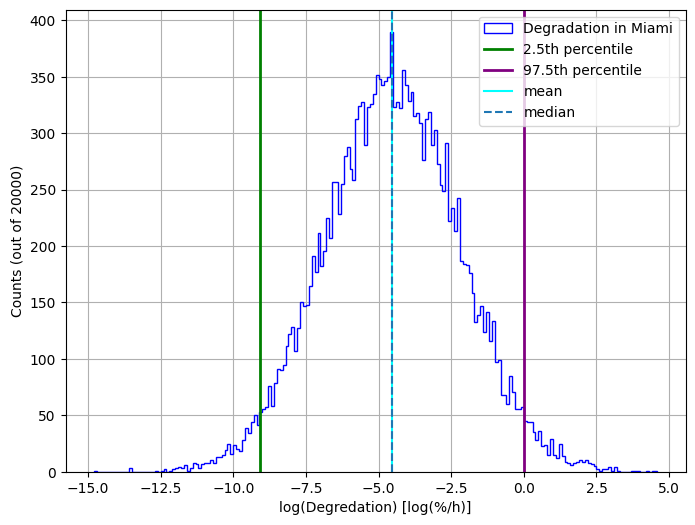

In [14]:
lnDeg = np.log10(results)
percentile_2p5 = np.percentile(lnDeg, 2.5)
percentile_97p5 = np.percentile(lnDeg, 97.5)
bin_edges = np.arange(lnDeg.min(), lnDeg.max() + 0.1, 0.1)

plt.figure(figsize=(8, 6))
plt.hist(
    lnDeg,
    bins=bin_edges,
    edgecolor="blue",
    histtype="step",
    linewidth=1,
    label="Degradation in Miami",
)

plt.axvline(percentile_2p5, color="green", label="2.5th percentile", linewidth=2.0)
plt.axvline(percentile_97p5, color="purple", label="97.5th percentile", linewidth=2.0)
plt.axvline(np.mean(lnDeg), color="cyan", label="mean")
plt.axvline(np.median(lnDeg), linestyle="--", label="median")
plt.xlabel("log(Degredation) [log(%/h)]")
plt.ylabel(f"Counts (out of {n})")

plt.legend()
plt.grid(True)
plt.show()